In [1]:
import numpy as np
import cv2
from PIL import Image
import open3d as o3d
import json

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

# from pyquaternion.quaternion import Quaternion
from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords
from utils import *

from typing import Tuple, List, Dict, Union

%matplotlib inline

In [2]:
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Obtaining a simple annotation

In [3]:
# Load the information from .txt file in JSON format
sample_path = '/home/sherlock/Documents/3d_obj_detection/anns/sample_0a0d6b8c2e884134a3b48df43d54c36a_file.txt'
# sample_path = '/home/gus/Documents/AI_S/ML/PF/sample_file/sample_ca9a282c9e77460f8360f564131a8af5_file.txt'

# This is a Dictionary of lists of dictionaries
data_json = load_file(sample_path)
data_json['instance'][0]

{'annotation_token': 'a42ec89706094b80bcbd4adafa3a83fd',
 'pointcloud_path': '/home/sherlock/Documents/3d_obj_detection/points/pc_anno_a42ec89706094b80bcbd4adafa3a83fd.txt',
 'pcl_shape': [3, 351],
 'img_pc_path': '/home/sherlock/Documents/3d_obj_detection/points_cam/img_pc_anno_a42ec89706094b80bcbd4adafa3a83fd.txt',
 'img_pcl_shape': [4, 351],
 'position_coord': [-3.3968256201254947,
  12.943522897281376,
  -0.31610390074512007],
 'wlh_values': [1.953, 5.03, 1.672],
 'orientation_value': 33.58812591701845,
 'category': 'vehicle'}

## Point cloud data

In [29]:
# Create instance metadata
annotation_metadata = data_json['instance'][0]

# point cloud
pointcloud_lidar = load_pcl_txt(annotation_metadata['pointcloud_path'], annotation_metadata['pcl_shape'])

# Plotting the segmented point cloud
Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])

## Retrieving image

In [5]:
# Retrieve annotation metadata from nuScenes
retrieve_annotation_metadata =  nusc.get('sample_annotation', annotation_metadata['annotation_token'])
# Obtain interest Camera
camera_channel = get_camera_data(nusc, retrieve_annotation_metadata['token'])
# Obtain sample data
sample_data = nusc.get('sample', retrieve_annotation_metadata['sample_token'])
# Sample data from cam Sensor
cam_data = nusc.get('sample_data', sample_data['data'][camera_channel])

## Plotting the current image frame

(-0.5, 1599.5, 899.5, -0.5)

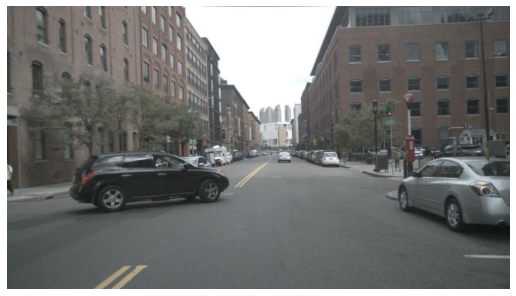

In [6]:
# Open image of the interest camera
im = Image.open(osp.join(nusc.dataroot, cam_data['filename']))

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.axis('off')

## Plotting the point cloud on the image

(-0.5, 1599.5, 899.5, -0.5)

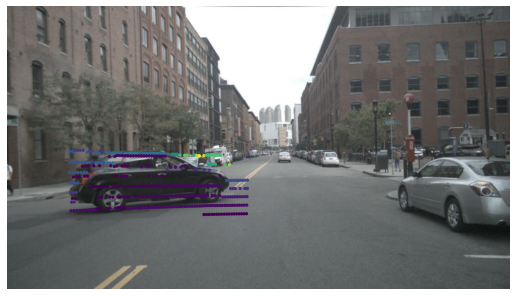

In [7]:
# point cloud
pointcloud_cam = load_pcl_txt(annotation_metadata['img_pc_path'], annotation_metadata['img_pcl_shape'])

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.scatter(pointcloud_cam[0, :], pointcloud_cam[1, :], c = pointcloud_cam[3, :], s = 5)
plt.axis('off')

## Instance segmentation

In [8]:
# Using the DBScan object
clustering = DBSCAN(eps = 1.0, min_samples = 20).fit(pointcloud_lidar.T)
# Clusters
clustering.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1,
       -1,  0, -1, -1, -1, -1,  0, -1, -1, -1,  0,  0, -1, -1, -1,  0,  0,
       -1, -1, -1,  0, -1, -1, -1,  0,  0, -1, -1, -1,  0, -1, -1,  0,  0,
        0,  0, -1, -1,  0,  0,  0, -1, -1,  0, -1, -1,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0, -1, -1,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0, -1, -1,  0,  0

In [37]:
# Number of unique clusters and Delete -1 (noisy) class
clusters = np.unique(clustering.labels_)[1:,]

for class_idx, cluster in enumerate(clusters):
    # Obtain the indeces of interest of the current cluster
    idx = np.where(clustering.labels_ == class_idx)[0]
    # Extract the point cloud of the current cluster
    pcl_temp = pointcloud_lidar.T[idx]
    
    # Plot the point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcl_temp)
    # visualizing the 3D point cloud
    o3d.visualization.draw_geometries([pcd])

## Computing clusters with open3D

In [23]:
# Plotting the segmented point cloud
Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1.0, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 6
point cloud has 6 clusters


## Computing plane

In [36]:
# Plotting the segmented point cloud
#Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

#pcd = o3d.geometry.PointCloud()
#pcd.points = o3d.utility.Vector3dVector(Velopoints)

plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([outlier_cloud])

Plane equation: -0.02x + 0.08y + 1.00z + 0.10 = 0
